## Metrics and Vizualizations to rate our scoring

P.S. по хорошему должна быть модель для скоринга, но (из-за недостатка данных) пока это просто оценивание наших пар и непосредственно нашего скоринга

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr, kendalltau
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

In [5]:
class MetricsCalculator:
    def __init__(self):
        self.scaler = MinMaxScaler()
    
    def prepare_data(self, predictions: List[Tuple], feedback: List[Tuple]) -> pd.DataFrame:
        pred_df = pd.DataFrame(predictions, columns=['peer1', 'peer2', 'score'])
        feedback_df = pd.DataFrame(feedback, columns=['peer1', 'peer2', 'rate'])
        
        merged = pd.merge(pred_df, feedback_df, on=['peer1', 'peer2'], how='inner')
        return merged
    
    def mean_absolute_error_metric(self, df: pd.DataFrame) -> float:
        normalized_scores = self.scaler.fit_transform(df[['score']])[:, 0] * 9 + 1
        return mean_absolute_error(df['rate'], normalized_scores)
    
    def root_mean_squared_error(self, df: pd.DataFrame) -> float:
        normalized_scores = self.scaler.fit_transform(df[['score']])[:, 0] * 9 + 1
        return np.sqrt(mean_squared_error(df['rate'], normalized_scores))
    
    def pearson_correlation(self, df: pd.DataFrame) -> float:
        correlation, p_value = pearsonr(df['score'], df['rate'])
        return correlation
    
    def top_k_precision(self, df: pd.DataFrame, k: int = 10) -> float:
        df_sorted_score = df.nlargest(k, 'score')
        df_sorted_rate = df.nlargest(k, 'rate')
        
        top_score_pairs = set(zip(df_sorted_score['peer1'], df_sorted_score['peer2']))
        top_rate_pairs = set(zip(df_sorted_rate['peer1'], df_sorted_rate['peer2']))
        
        intersection = len(top_score_pairs.intersection(top_rate_pairs))
        return intersection / k
    
    def satisfaction_rate(self, df: pd.DataFrame, threshold: float = 7.0) -> float:
        high_score_pairs = df[df['score'] >= df['score'].quantile(0.8)]
        satisfied_pairs = high_score_pairs[high_score_pairs['rate'] >= threshold]
        return len(satisfied_pairs) / len(high_score_pairs) if len(high_score_pairs) > 0 else 0
    
    
    def calculate_all_metrics(self, predictions: List[Tuple], feedback: List[Tuple]) -> Dict[str, float]:
        df = self.prepare_data(predictions, feedback)
        
        metrics = {
            'MAE': self.mean_absolute_error_metric(df),
            'RMSE': self.root_mean_squared_error(df),
            'Pearson_Correlation': self.pearson_correlation(df),
            'Top_10_Precision': self.top_k_precision(df, k=10),
            'Satisfaction_Rate': self.satisfaction_rate(df),
        }
        
        return metrics

In [8]:
class MetricsVisualizer:
    def __init__(self):
        plt.style.use('seaborn-v0_8')
        self.colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD']
    
    def plot_score_vs_rating_scatter(self, df: pd.DataFrame):
        plt.figure(figsize=(10, 6))
        plt.scatter(df['score'], df['rate'], alpha=0.6, color=self.colors[0])
        
        z = np.polyfit(df['score'], df['rate'], 1)
        p = np.poly1d(z)
        plt.plot(df['score'], p(df['score']), "r--", alpha=0.8)
        
        plt.xlabel('Predicted Score')
        plt.ylabel('User Rating')
        plt.title('Predicted Score vs User Rating')
        plt.grid(True, alpha=0.3)
        
        correlation = np.corrcoef(df['score'], df['rate'])[0, 1]
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes, fontsize=12, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    def plot_residuals(self, df: pd.DataFrame):
        normalized_scores = MinMaxScaler().fit_transform(df[['score']])[:, 0] * 9 + 1
        residuals = df['rate'] - normalized_scores
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(normalized_scores, residuals, alpha=0.6, color=self.colors[1])
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        plt.xlabel('Predicted Rating (Normalized)')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Predicted')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=20, alpha=0.7, color=self.colors[2])
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Residuals')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_metrics_comparison(self, metrics: Dict[str, float]):
        metric_names = list(metrics.keys())
        metric_values = list(metrics.values())
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(metric_names, metric_values, color=self.colors[:len(metric_names)])
        
        plt.ylabel('Metric Value')
        plt.title('Model Performance Metrics')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars, metric_values):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def plot_rating_distribution(self, df: pd.DataFrame):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(df['score'], bins=20, alpha=0.7, color=self.colors[3], label='Predicted Scores')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Predicted Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(df['rate'], bins=20, alpha=0.7, color=self.colors[4], label='User Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Frequency')
        plt.title('Distribution of User Ratings')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_error_by_score_range(self, df: pd.DataFrame):
        normalized_scores = MinMaxScaler().fit_transform(df[['score']])[:, 0] * 9 + 1
        df_temp = df.copy()
        df_temp['normalized_score'] = normalized_scores
        df_temp['error'] = np.abs(df_temp['rate'] - normalized_scores)
        
        df_temp['score_range'] = pd.cut(df_temp['normalized_score'], 
                                       bins=[0, 3, 5, 7, 10], 
                                       labels=['Low (1-3)', 'Medium (3-5)', 'High (5-7)', 'Very High (7-10)'])
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_temp, x='score_range', y='error', palette='viridis')
        plt.ylabel('Absolute Error')
        plt.xlabel('Score Range')
        plt.title('Prediction Error by Score Range')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def create_comprehensive_report(self, predictions: List[Tuple], feedback: List[Tuple]):
        calculator = MetricsCalculator()
        df = calculator.prepare_data(predictions, feedback)
        metrics = calculator.calculate_all_metrics(predictions, feedback)
        
        print("=== COMPREHENSIVE METRICS REPORT ===\n")
        
        print("1. Regression Metrics:")
        print(f"   Mean Absolute Error (MAE): {metrics['MAE']:.3f}")
        print(f"   Root Mean Squared Error (RMSE): {metrics['RMSE']:.3f}")
        
        print("\n2. Correlation Metrics:")
        print(f"   Pearson Correlation: {metrics['Pearson_Correlation']:.3f}")
        
        print("\n3. Ranking Metrics:")
        print(f"   Top-10 Precision: {metrics['Top_10_Precision']:.3f}")
        
        print("\n4. Business Metrics:")
        print(f"   Satisfaction Rate: {metrics['Satisfaction_Rate']:.3f}")
        
        print("\n=== VISUALIZATIONS ===")
        
        self.plot_score_vs_rating_scatter(df)
        self.plot_residuals(df)
        self.plot_metrics_comparison(metrics)
        self.plot_rating_distribution(df)
        self.plot_error_by_score_range(df)
        
        return metrics, df

=== COMPREHENSIVE METRICS REPORT ===

1. Regression Metrics:
   Mean Absolute Error (MAE): 1.894
   Root Mean Squared Error (RMSE): 2.264

2. Correlation Metrics:
   Pearson Correlation: 0.997

3. Ranking Metrics:
   Top-10 Precision: 1.000

4. Business Metrics:
   Satisfaction Rate: 1.000

=== VISUALIZATIONS ===


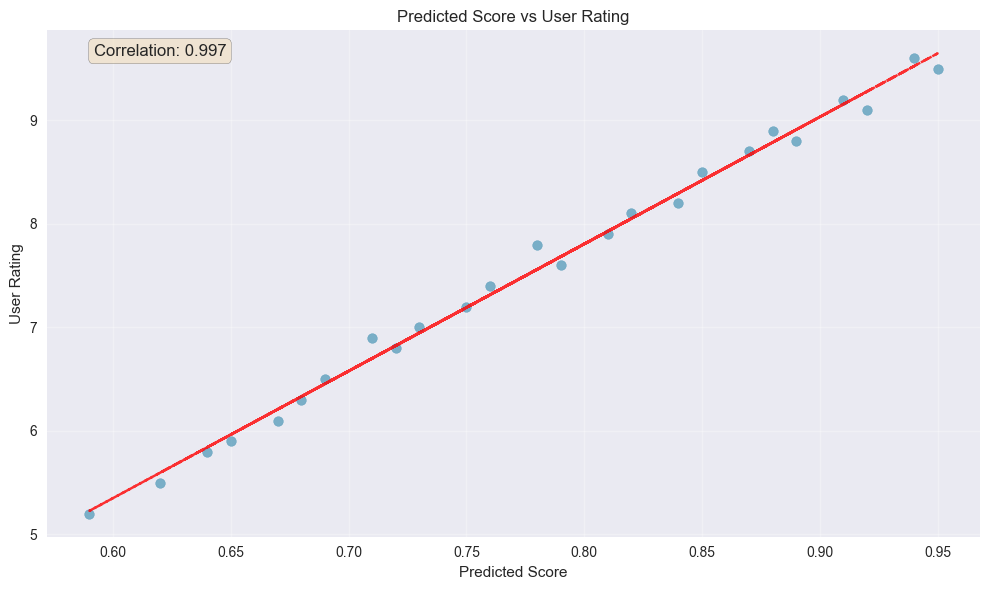

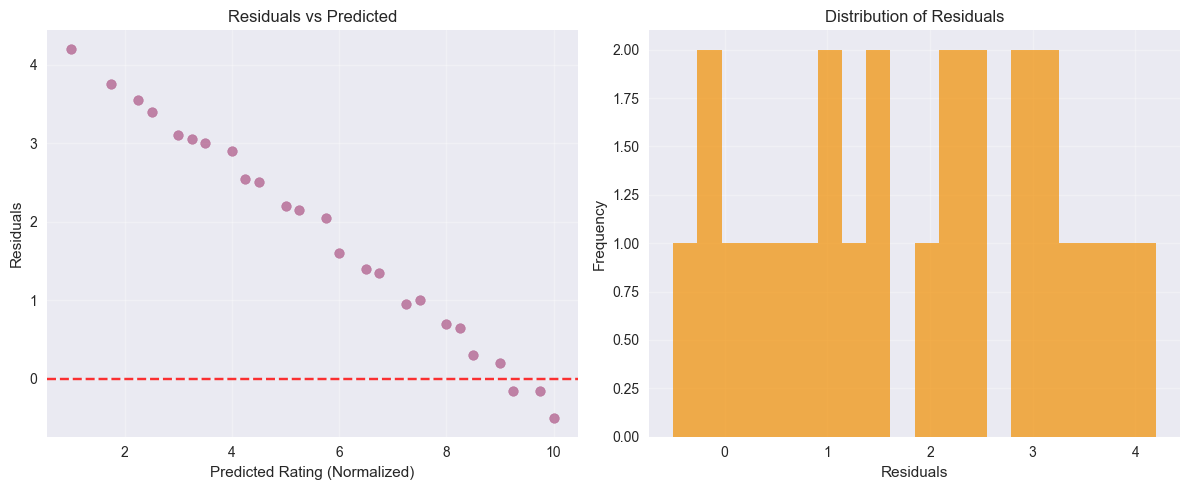

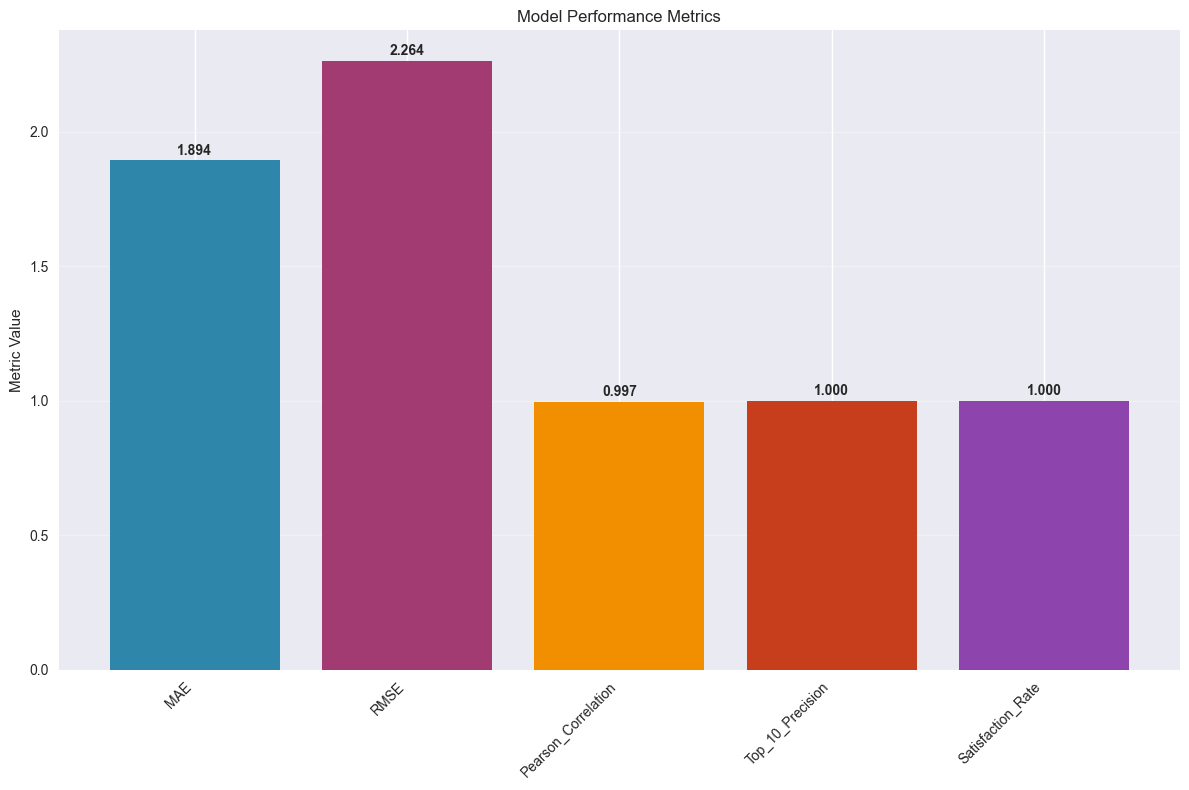

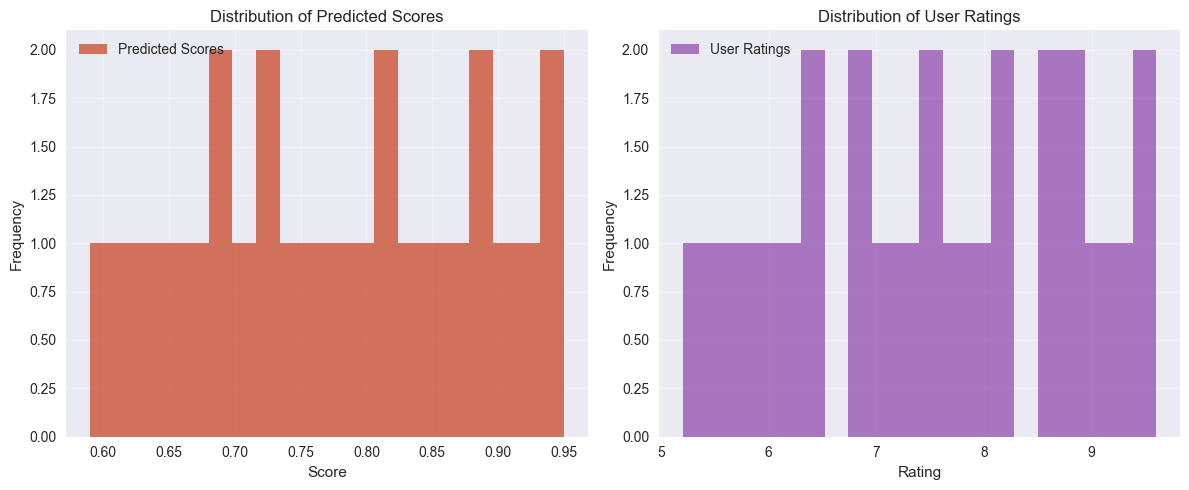

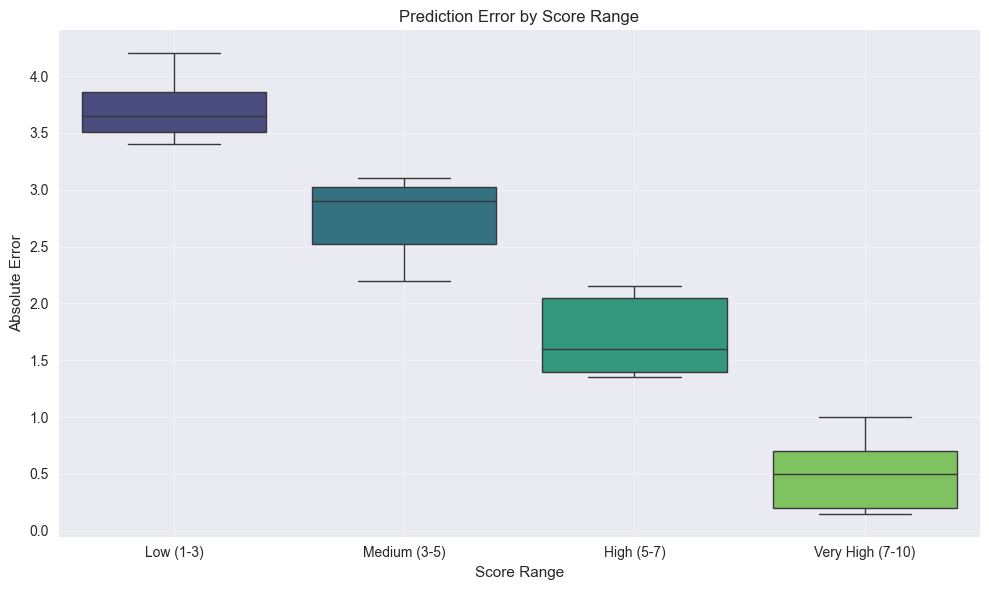

In [9]:
predictions = [
    (1, 2, 0.85), (3, 4, 0.72), (5, 6, 0.91), (7, 8, 0.65), (9, 10, 0.78),
    (11, 12, 0.88), (13, 14, 0.59), (15, 16, 0.94), (17, 18, 0.67), (19, 20, 0.82),
    (21, 22, 0.75), (23, 24, 0.69), (25, 26, 0.87), (27, 28, 0.73), (29, 30, 0.92),
    (31, 32, 0.64), (33, 34, 0.81), (35, 36, 0.76), (37, 38, 0.89), (39, 40, 0.68),
    (41, 42, 0.84), (43, 44, 0.71), (45, 46, 0.95), (47, 48, 0.62), (49, 50, 0.79)
]

feedback = [
    (1, 2, 8.5), (3, 4, 6.8), (5, 6, 9.2), (7, 8, 5.9), (9, 10, 7.8),
    (11, 12, 8.9), (13, 14, 5.2), (15, 16, 9.6), (17, 18, 6.1), (19, 20, 8.1),
    (21, 22, 7.2), (23, 24, 6.5), (25, 26, 8.7), (27, 28, 7.0), (29, 30, 9.1),
    (31, 32, 5.8), (33, 34, 7.9), (35, 36, 7.4), (37, 38, 8.8), (39, 40, 6.3),
    (41, 42, 8.2), (43, 44, 6.9), (45, 46, 9.5), (47, 48, 5.5), (49, 50, 7.6)
]

calculator = MetricsCalculator()
visualizer = MetricsVisualizer()

metrics, df = visualizer.create_comprehensive_report(predictions, feedback)

# Metrics

### Regression Metrics (отклонение предсказанных scores от реальных оценок юзеров):
- MAE (Mean Absolute Error) 
- RMSE (Root Mean Squared Error)

### Correlation Metrics (связь между предсказанными скорами и реальными оценками):
- Pearson Correlation 


### Ranking Metrics: ("Правильно ли модель выбирает лучшие пары?")
- Top-K Precision (сколько из топ-10 пар по модели попадают в топ-10 по реальным оценкам. важно, чтобы лучшие предсказания модели действительно были лучшими)


### Business metrics (Satisfaction Rate)
- Показывает долю высокорейтинговых пар (top 20% по модели), которые получили высокие оценки (>=7.0)
- Напрямую связана с бизнес-целью: пользователи должны быть довольны рекомендованными парами
- "Довольны ли пользователи рекомендациями?"

## Vizualizations

### Predicted Score vs User Rating 
- Ideal: точки лежат близко к прямой линии с положительным наклоном
- Problems: разброс точек, нелинейная зависимость, выбросы
- Что показывает: общее качество оценивания

## Residuals Analysis
- Помогает найти систематические проблемы
### Residuals vs Predicted
- Residuals = Real rate (обратная связь) - score
- Ideal: точки случайно разбросаны вокруг нулевой линии
- Bad: Другие паттерны (Воронки, кривая и тп)
### Distribution of Residuals
- Ideal: нормальное распределение с центром в 0
- Bad: cмещение от нуля, несимметричность, длинные хвосты


### Model Performance Metrics
Просто все метрики в одном месте

### Distribution Comparison (как распределены реальный rate и наш score)
- Ideal: Похожие формы
- Bad: Разные формы
- Что показывает: как правильно происходит оценивание

### Prediction Error by Score Range
- Как качество (rate - score or residual) зависит от диапазона скоров
- Ideal: одинаковые box plots
- Bad: разные размеры (score лучше/хуже работает в определенных диапазонах), outliers (есть проблемные случаи)
- Что показывает: в каких случаях scoring плохой